***
# **FloodProofs Labs - HMC Training - Maps Analyzer** 

<img style="float: left; padding-right: 80px; padding-left: 5px;" src="img/logo_hmc.png" width="200px" align=”left” >

In the laboratory of **HMC maps** we will perform the following points:
   * Configure the libraries and the dependecies of the laboratory;
   * Read the configuration file of the laboratory;
   * Read the static datasets of terrain, river networks and outlet sections;
   * Read the dynamic datasets of the maps (forcing and outcome datasets);
   * Plot the maps of forcing variables;
   * Plot the maps of outcome variables.    


## **Import libraries and dependencies**

In [1]:
# Notebook configuration
%matplotlib inline
%matplotlib widget

# Noteboook extentions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#from IPython.display import Image
#from IPython.core.display import HTML 

# Libraries
import os
import glob

from library.jupyter_generic.lib_jupyter_data_io_json import read_file_settings
from library.jupyter_generic.lib_jupyter_data_io_generic import define_file_path, define_file_template, fill_file_template, \
    create_darray_maps, define_file_var, create_time_range, validate_time_step, organize_file_template, get_path_root, get_path_folders, get_folders_time

from library.jupyter_generic.lib_jupyter_data_geo_ascii import read_data_grid
from library.jupyter_generic.lib_jupyter_data_geo_shapefile import read_data_section, find_data_section

from library.jupyter_generic.lib_jupyter_data_io_netcdf import read_file_maps

from library.jupyter_generic.lib_jupyter_plot_map import plot_map_terrain, plot_map_var

# Define configuration file
file_name_settings="fp_labs_analyzer_hmc_maps.json"

# Info
print(' ==> Libraries loaded')

 ==> Libraries loaded



### **Configure the flood-proofs laboratory**
- Load the configuration file:

In [2]:
# Read data from settings algorithm file
settings_info = read_file_settings(file_name_settings)

# Info
print(' ==> Settings information loaded')

 ==> Settings information loaded


- Define the static and dynamic file paths:

In [3]:
# Define static and dynamic file path(s)
file_path_dset_static = define_file_path(settings_info['source']['static'])
file_path_dset_dynamic = define_file_path(settings_info['source']['dynamic'])
file_path_dset_plot = define_file_path(settings_info['destination']['plot'])

In [4]:
# Define dynamic path root
file_path_dynamic_root = get_path_root(list(file_path_dset_dynamic.values())[0])

In [5]:
# Define list of available folders
list_folder_dynamic_root = get_path_folders(file_path_dynamic_root)

### **Read the static datasets**
- Read the terrain file in ascii format

In [6]:
# Read terrain datasets
dset_terrain = read_data_grid(file_path_dset_static['terrain'])

- Read the sections information in vector format

In [7]:
# Read sections shapefile
dset_section = read_data_section(file_path_dset_static['sections'])

### **Select the "time run" and the "time analysis"**
- Select the time run to select the case-study

In [8]:
# Define list of available runs based on folders name
time_run_list = get_folders_time(list_folder_dynamic_root)

In [9]:
# Display available time run
time_run_selection = widgets.Select(options=time_run_list, description='Time Run', disabled=False)
display(time_run_selection)  

Select(description='Time Run', options=('2021-01-22 06:00', '2021-01-28 12:00'), value='2021-01-22 06:00')

In [10]:
# Parser the selection from the scroll menu
time_run_value = time_run_selection.value

# Set time run in the setting info object
settings_info['time']['time_run'] = time_run_value

# Info time run
print(' ==> Time Run: ' + settings_info['time']['time_run'] )

 ==> Time Run: 2021-01-22 06:00


- Select the time analysis to select the a step of case-study

In [11]:
_, time_analysis_list = create_time_range(
    settings_info['time']['time_run'],
    time_obs_period=settings_info['time']['time_observed_period'],
    time_obs_freq=settings_info['time']['time_observed_frequency'])

In [12]:
# Display available time run
time_analysis_selection = widgets.Select(options=time_analysis_list, description='Time Analysis', disabled=False)
display(time_analysis_selection) 

Select(description='Time Analysis', options=('2021-01-22 06:00', '2021-01-22 05:00', '2021-01-22 04:00', '2021…

In [13]:
# Parser the selection from the scroll menu
time_analysis_value = time_analysis_selection.value

# Set time run in the setting info object
settings_info['time']['time_analysis'] = time_analysis_value

# Info time run
print(' ==> Time Analysis: ' + settings_info['time']['time_analysis'] )

 ==> Time Analysis: 2021-01-22 06:00


- Define the information of section, domain and time

In [14]:
# Get domain, time and variables information
info_domain = settings_info['info']['domain_name']
info_time_run = settings_info['time']['time_run']
info_time_analysis = settings_info['time']['time_analysis']
info_time_range, _ = create_time_range(
    info_time_run,
    time_obs_period=settings_info['time']['time_observed_period'],
    time_obs_freq=settings_info['time']['time_observed_frequency'])
info_var_list_forcing_obs_ws = settings_info['info']['var_list_forcing_obs_ws']
info_var_list_outcome = settings_info['info']['var_list_outcome']

# Validate time analysis
valid_time_analysis = validate_time_step(info_time_analysis, info_time_range)

# Info
print(' ==> Time Run: ' + info_time_run)
print(' ==> Time Analysis: ' + info_time_analysis + ' == Validate: ' + str(valid_time_analysis))
print(' ==> Forcing Variables: ' + str(info_var_list_forcing_obs_ws))
print(' ==> Outcome Variables: ' + str(info_var_list_outcome))

 ==> Time Run: 2021-01-22 06:00
 ==> Time Analysis: 2021-01-22 06:00 == Validate: True
 ==> Forcing Variables: ['Rain', 'Air_Temperature', 'Relative_Humidity']
 ==> Outcome Variables: ['SM', 'LST']


### **Read the dynamic datasets**
- Organize the dynamic datasets

In [15]:
# Fill dynamic file path(s)
file_path_dset_dynamic_collections = {}
file_path_dset_plot_collections = {}

# Info start
print(' ==> Organize dynamic data ... ')
for info_time_step in info_time_range:

    string_time_step = info_time_step.strftime('%Y-%m-%d %H:00')
    
    print(' ===> TimeStep ' + string_time_step + ' ... ')

    file_template_filled = define_file_template(info_time_run, info_time_step,
                                                domain_name=info_domain, template_default=settings_info['template'])
    file_path_dset_dynamic_filled = fill_file_template(file_path_dset_dynamic,
                                                template_filled=file_template_filled,
                                                template_default=settings_info['template'])
    file_path_dset_plot_filled = fill_file_template(file_path_dset_plot,
                                             template_filled=file_template_filled,
                                             template_default=settings_info['template'])

    file_path_dset_dynamic_collections[string_time_step] = file_path_dset_dynamic_filled
    file_path_dset_plot_collections[string_time_step] = file_path_dset_plot_filled
    
    print(' ===> TimeStep ' + string_time_step + ' ... DONE')

file_name_forcing_obs_ws_list, file_time_forcing_obs_ws_list = organize_file_template(
    file_path_dset_dynamic_collections, file_dataset_tag='maps_forcing_obs_ws')

file_name_outcome_list, file_time_outcome_list = organize_file_template(
    file_path_dset_dynamic_collections, file_dataset_tag='maps_outcome')

# Info end 
print(' ==> Organize dynamic data ... DONE')

 ==> Organize dynamic data ... 
 ===> TimeStep 2021-01-22 06:00 ... 
 ===> TimeStep 2021-01-22 06:00 ... DONE
 ===> TimeStep 2021-01-22 05:00 ... 
 ===> TimeStep 2021-01-22 05:00 ... DONE
 ===> TimeStep 2021-01-22 04:00 ... 
 ===> TimeStep 2021-01-22 04:00 ... DONE
 ===> TimeStep 2021-01-22 03:00 ... 
 ===> TimeStep 2021-01-22 03:00 ... DONE
 ===> TimeStep 2021-01-22 02:00 ... 
 ===> TimeStep 2021-01-22 02:00 ... DONE
 ==> Organize dynamic data ... DONE


- Get the dynamic datasets

In [16]:
# Get maps of forcing and outcome datasets
print(' ==> Get dynamic data ... ')

# Forcing datasets 
dset_maps_forcing_obs_ws_collections = read_file_maps(
    file_name_forcing_obs_ws_list, file_time_forcing_obs_ws_list,
    file_vars_list_select=info_var_list_forcing_obs_ws)
# Outcome datasets
dset_maps_outcome_collections = read_file_maps(
    file_name_outcome_list, file_time_outcome_list,
    file_vars_list_select=info_var_list_outcome)

# Info end
print(' ==> Get dynamic data ... DONE')

 ==> Get dynamic data ... 
 ==> Get dynamic data ... DONE


- Select the variable(s) and create the dataframe

In [17]:
# Select variable(s) to plot maps
darray_map_rain, attrs_map_rain = create_darray_maps(
    dset_maps_forcing_obs_ws_collections,
    var_time=info_time_analysis, var_name_in='Rain', var_name_out='rain')
darray_map_airt, attrs_map_airt = create_darray_maps(
    dset_maps_forcing_obs_ws_collections,
    var_time=info_time_analysis, var_name_in='Air_Temperature', var_name_out='air_temperature')
darray_map_rh, attrs_map_rh = create_darray_maps(
    dset_maps_forcing_obs_ws_collections,
    var_time=info_time_analysis, var_name_in='Relative_Humidity', var_name_out='relative_humidity')

darray_map_sm, attrs_map_sm = create_darray_maps(
    dset_maps_outcome_collections,
    var_time=info_time_analysis, var_name_in='SM', var_name_out='soil_moisture')
darray_map_lst, attrs_map_lst = create_darray_maps(
    dset_maps_outcome_collections,
    var_time=info_time_analysis, var_name_in='LST', var_name_out='land_surface_temperature')

### **Plot the dynamic datasets in maps format**
- Create the plot of the **soil moisture map**:

In [18]:
# Plot map soil moisture
file_name_map_sm = define_file_var(file_path_dset_plot_collections, file_time=info_time_analysis,
                                   var_name='soil_moisture', dataset_name='maps_outcome')

plot_map_var(file_name_map_sm, darray_map_sm, info_time_analysis,
             var_name_data='soil_moisture', var_units='[-]', var_name_geo_x='Longitude', var_name_geo_y='Latitude',
             var_limit_min=0, var_limit_max=1)
#Image(filename = file_name_map_sm, width=1000, height=1000)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- Create the plot of the **air temperature map**:

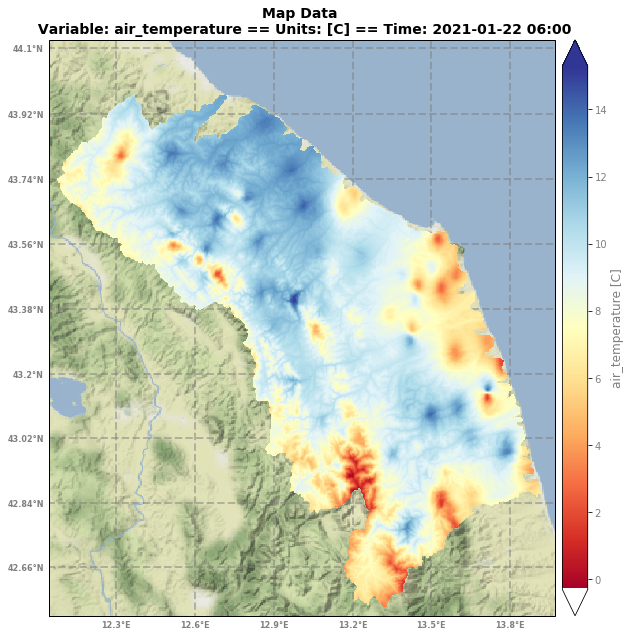

In [23]:
# Plot map air temperature
file_name_map_airt = define_file_var(file_path_dset_plot_collections, file_time=info_time_analysis,
                                     var_name='air_temperature', dataset_name='maps_forcing_obs_ws')
plot_map_var(file_name_map_airt, darray_map_airt, info_time_analysis,
             var_name_data='air_temperature', var_units='[C]', var_name_geo_x='longitude', var_name_geo_y='latitude')
#Image(filename = file_name_map_airt, width=1000, height=1000)

- Create the plots of the **air temperature maps** for the defined period:

In [20]:
# Noteboook configuration
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Image

In [21]:

# Iterate over selected period to plot all images
file_path_collections = {}

# Info start
print(' ==> Iterate over dynamic data ... ')
for info_time_step in info_time_range:

    string_time_step = info_time_step.strftime('%Y-%m-%d %H:00')
    
    print(' ===> TimeStep ' + string_time_step + ' ... ')
    
    file_template_filled = define_file_template(info_time_run, info_time_step,
                                                domain_name=info_domain, template_default=settings_info['template'])
    file_path_dset_plot_filled = fill_file_template(file_path_dset_plot,
                                                template_filled=file_template_filled,
                                                template_default=settings_info['template'])
    
    darray_map_airt, attrs_map_airt = create_darray_maps(dset_maps_forcing_obs_ws_collections,
    var_time=string_time_step, var_name_in='Air_Temperature', var_name_out='air_temperature')
    
    file_path_collections[string_time_step] = file_path_dset_plot_filled
    file_path_map = define_file_var(file_path_collections, file_time=string_time_step,
                                    var_name='air_temperature', dataset_name='maps_forcing_obs_ws')
    
    plot_map_var(file_path_map, darray_map_airt, string_time_step,
             var_name_data='air_temperature', var_units='[C]', var_name_geo_x='longitude', var_name_geo_y='latitude',
                fig_show=False)

    print(' ===> TimeStep ' + string_time_step + ' ... DONE')

folder_name_map, file_name_map = os.path.split(file_path_map)
string_list_map = os.path.join(folder_name_map, '*' + 'air_temperature' + '*')
file_list_map = glob.glob(string_list_map)

# Info end
print(' ==> Iterate over dynamic data ... DONE')

 ==> Iterate over dynamic data ... 
 ===> TimeStep 2021-01-22 06:00 ... 
 ===> TimeStep 2021-01-22 06:00 ... DONE
 ===> TimeStep 2021-01-22 05:00 ... 
 ===> TimeStep 2021-01-22 05:00 ... DONE
 ===> TimeStep 2021-01-22 04:00 ... 
 ===> TimeStep 2021-01-22 04:00 ... DONE
 ===> TimeStep 2021-01-22 03:00 ... 
 ===> TimeStep 2021-01-22 03:00 ... DONE
 ===> TimeStep 2021-01-22 02:00 ... 
 ===> TimeStep 2021-01-22 02:00 ... DONE
 ==> Iterate over dynamic data ... DONE


In [22]:
# Search files and order in descending mode
file_list = glob.glob(os.path.join(folder_name_map, '*air_temperature*'))
file_list.sort(reverse=True)
@interact
def show_images(file=file_list):
    display(Image(file,  width=750, height=750))

interactive(children=(Dropdown(description='file', options=('/home/fabio/fp_labs_datasets/images/hmc.forcing_a…

**Training on-the-job**
- Download/Organize the static and dynamic datasets for a different "time run";
- Select a different case-study (time run);
- Select a different analysis step (time analysis);
- Add/change the variables in the maps plot (have to check the names of the variables in the netcdf forcing or outcome files);
- Add/change the plot of gridded variables (for example using a different map background);
- ...